## Executive summary

**Note on reproducibility:**  
All tables and figures in `outputs/` were generated offline (training, inference, and analysis) and committed to this repository. This notebook documents the evaluation workflow and reads from those committed artifacts to ensure transparency and reproducibility. A minimal, non-executable code sketch illustrating the training and inference pipeline is included in the Appendix for context.

This notebook is a *curated* artifact demonstrating an empirical ML evaluation workflow using saved ZooBot predictions on NGVS galaxy images. It is intentionally focused on **evaluation and failure analysis**, rather than model training or benchmark optimization.

- **Task:** Binary morphology classification (**E vs not-E**), evaluated across a heterogeneous set of NGVS structural classes (E, ES, EI, SI, S, I). These subclasses provide a natural setting for subgroup analysis under domain shift.
- **Method:** Transfer learning with a pretrained ZooBot CNN. All results shown here are derived from saved prediction tables; no model training occurs in this notebook.
- **Key evaluation artifacts:**  
  - **High-confidence errors:** Confident-but-incorrect predictions, central to reliability and safety-style evaluation  
  - **High-confidence predictions:** Representative correct cases used as a qualitative sanity check  
  - **Low-confidence predictions:** Ambiguous cases near class boundaries, highlighting uncertainty in the learned representation  
  - **Decision-boundary analysis:** Predictions closest to the classification threshold, illustrating transition regions and model ambiguity  
  - **Subgroup slices:** Performance summaries by `NGVS_morph_code` to expose class-conditional behavior

**Outputs included in this repository:**
- `outputs/figures/high_confidence_errors_full.png`
- `outputs/figures/top_confidence_full.png`
- `outputs/figures/bottom_confidence_full.png`
- `outputs/figures/pred_boundary.png`
- Aggregated metrics and subgroup tables in `outputs/tables/`

Overall, this setting serves as a practical testbed for examining model confidence, subgroup behavior, and failure modes under limited supervision and distribution shift—core concerns in applied ML reliability and AI safety.


## Model context: ZooBot in an ML framework

ZooBot is a convolutional neural network (CNN) framework designed for large-scale image classification of galaxies, built on standard deep learning components (PyTorch / PyTorch Lightning) and pretrained on a large corpus of astronomical images. Conceptually, ZooBot plays a role similar to ImageNet-pretrained ResNet or ViT models in computer vision: it provides a strong, generic visual representation that can be adapted to downstream tasks via transfer learning.

In this project, ZooBot is used as a **pretrained visual backbone**, with emphasis on:
- adapting the representation to a new domain (NGVS images, which differ in resolution, depth, and noise characteristics from the pretraining data),
- fine-tuning under **limited supervision** (label-scarce regimes),
- and evaluating model reliability via qualitative failure analysis rather than optimizing for benchmark performance.

### How ZooBot is used here
- The base ZooBot model is initialized from a public pretrained checkpoint.
- ZooBot uses a ConvNeXt backbone; unless otherwise noted, I adopt **ConvNeXt-nano** as the default encoder, motivated by its strong transfer performance under limited supervision and favorable compute efficiency. A larger ConvNeXt-Base model is used for size ablation in the broader study.
- I fine-tune either:
  - **head-only** (training only the final classification layers), or
  - **full / partial fine-tuning** (unfreezing deeper layers of the network).
- Predictions are generated as probabilistic outputs for a binary task (E vs not-E) and saved to disk for downstream analysis.

In this work, I was responsible for:
- constructing the training and evaluation catalog from raw metadata and images,
- selecting fine-tuning depth and supervision regimes,
- designing evaluation slices and diagnostics,
- and generating and curating qualitative failure analyses.

Importantly, this notebook does **not** aim to introduce a new architecture. Instead, it treats ZooBot as a realistic pretrained vision model and focuses on evaluation questions that are broadly relevant to ML systems deployed under domain shift and data scarcity.

**References:**
- ZooBot project overview and code: https://github.com/mwalmsley/zoobot  
- Walmsley et al. (2022), *Practical galaxy morphology tools from deep supervised representation learning*
- Walmsley et al. (2023), *Zoobot: Adaptable Deep Learning Models for Galaxy Morphology*
- Liu et al. (2022), *A ConvNet for the 2020s (ConvNeXt)*, CVPR

## 1) Load saved predictions (source of truth)

The evaluation in this notebook uses a saved predictions CSV produced by the full training, inference, and aggregation pipeline. The table contains per-image predictions, ground-truth labels, file paths, and metadata required for subgroup and qualitative analysis.

For the curated example, we highlight the **multi1090 structural** run and the **full fine-tune** prediction column.


In [28]:
import os
import numpy as np
import pandas as pd

# ---------------- CONFIG ----------------
PREDICTIONS_CSV = "outputs/tables/multi1090_structural_predictions_agg_v2.csv"  # 
TRUE_COL = "is_E"
PRED_COL = "is_E_pred_full"   # full fine-tune probability for the positive class
ID_COL   = "id_str"
PATH_COL = "file_loc"
MORPH_COL = "NGVS_morph_code"

df = pd.read_csv(PREDICTIONS_CSV)

# Minimal cleaning
df = df.dropna(subset=[TRUE_COL, PRED_COL, PATH_COL]).copy()
df[TRUE_COL] = df[TRUE_COL].astype(int)

df[[ID_COL, PATH_COL, MORPH_COL, TRUE_COL, PRED_COL]].head()

id_str  \
0  NGVSJ12:03:45.06+27:37:02.0   
1  NGVSJ12:04:51.83+26:59:33.1   
2  NGVSJ12:07:45.73+12:03:37.0   
3  NGVSJ12:08:01.21+12:48:56.0   
4  NGVSJ12:08:04.43+13:13:17.0   

                                            file_loc NGVS_morph_code  is_E  \
0  /arc/home/mkurzner/zoobot_ngvs_cutouts/NGVSJ12...              ES     0   
1  /arc/home/mkurzner/zoobot_ngvs_cutouts/NGVSJ12...               S     0   
2  /arc/home/mkurzner/zoobot_ngvs_cutouts/NGVSJ12...               E     1   
3  /arc/home/mkurzner/zoobot_ngvs_cutouts/NGVSJ12...               E     1   
4  /arc/home/mkurzner/zoobot_ngvs_cutouts/NGVSJ12...               E     1   

   is_E_pred_full  
0        0.033486  
1        0.035134  
2        0.997114  
3        0.969526  
4        0.987558

## 2) Lightweight quantitative summaries (context-setting only)

We report a small set of standard quantitative summaries to provide context, not to optimize or rank models. These metrics give a coarse global view of performance and separability, but are insufficient for diagnosing safety-relevant failure modes such as confident misclassification, subgroup brittleness, or miscalibration under distribution shift. Those behaviors are examined directly in Section 4 via confidence-stratified qualitative analysis.

### Notes on reported metrics

- **Accuracy (threshold = 0.5)** is reported for interpretability and to anchor confusion-matrix summaries.
- **ROC–AUC** provides a threshold-independent measure of separability but does not capture calibration or confidence extremes.
- **Expected Calibration Error (ECE)** is included as a coarse descriptive summary of confidence alignment; calibration behavior is primarily examined through qualitative, confidence-stratified diagnostics in Section 4.


In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# --- Core columns used throughout ---
df["y"] = df[TRUE_COL].astype(int)
df["p"] = df[PRED_COL].astype(float)

# Binary decision threshold chosen for interpretability
THRESH = 0.5
df["yhat"] = (df["p"] >= THRESH).astype(int)
df["correct"] = (df["yhat"] == df["y"])


In [67]:


def expected_calibration_error(y_true, y_prob, n_bins=10, threshold=0.5):
    """
    Simple ECE with equal-width bins.
    Descriptive summary only (not a definitive calibration audit).
    """
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    for i in range(n_bins):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i + 1])
        if mask.sum() == 0:
            continue
        acc = (y_true[mask] == (y_prob[mask] >= threshold)).mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / len(y_true)) * abs(acc - conf)

    return float(ece)


### Metrics 

In [49]:
acc = accuracy_score(df["y"], df["yhat"])
roc_auc = roc_auc_score(df["y"], df["p"])
ece = expected_calibration_error(df["y"].values, df["p"].values, n_bins=10, threshold=THRESH)

n_total = len(df)
pos_rate = df["y"].mean()

metrics = pd.DataFrame(
    {
        "Metric": [
            "N examples",
            "Positive rate (E)",
            f"Accuracy (threshold = {THRESH:.1f})",
            "ROC–AUC",
            "ECE (10 bins, descriptive)",
        ],
        "Value": [
            f"{n_total:,}",
            f"{pos_rate:.3f}",
            f"{acc:.3f}",
            f"{roc_auc:.3f}",
            f"{ece:.3f}",
        ],
    }
)

metrics


Metric  Value
0                  N examples  3,684
1           Positive rate (E)  0.840
2  Accuracy (threshold = 0.5)  0.951
3                     ROC–AUC  0.975
4  ECE (10 bins, descriptive)  0.106

In [63]:
cm = confusion_matrix(df["y"], df["yhat"])

cm_counts = pd.DataFrame(
    cm,
    index=["True not-E", "True E"],
    columns=["Pred not-E", "Pred E"]
)

cm_row_norm = pd.DataFrame(
    cm / cm.sum(axis=1, keepdims=True),
    index=["True not-E", "True E"],
    columns=["Pred not-E", "Pred E"]
).round(3)

cm_counts



Pred not-E  Pred E
True not-E       0.759   0.241
True E           0.012   0.988

In [64]:
cm_row_norm

Pred not-E  Pred E
True not-E       0.759   0.241
True E           0.012   0.988

### Subgroup analysis (sample size, accuracy, mean predicted p(E))

In [61]:
subgroup = (
    df.groupby(MORPH_COL)
      .agg(
          n=("y", "count"),
          accuracy=("correct", "mean"),
          mean_pE=("p", "mean"),
      )
      .sort_values("n", ascending=False)
      .reset_index()
)

LOW_N = 30
subgroup["accuracy"] = subgroup["accuracy"].round(3)
subgroup["mean_pE"] = subgroup["mean_pE"].round(3)
subgroup["note"] = subgroup["n"].apply(lambda x: "low-N" if x < LOW_N else "")

subgroup


NGVS_morph_code     n  accuracy  mean_pE   note
0               E  3096     0.988    0.963       
1              ES   276     0.725    0.327       
2              EI   191     0.675    0.387       
3               S    86     1.000    0.042       
4               I    25     0.840    0.223  low-N
5              SI    10     1.000    0.026  low-N

### Subgroup summary excluding rare and highly disturbed morphologies

The table below excludes the rare and highly disturbed `I` and `SI` structural codes, which have small sample sizes and inherently ambiguous morphology, to provide a more stable view of subgroup performance.


In [62]:
subgroup_common = subgroup[~subgroup[MORPH_COL].isin(["SI", "I"])].copy()
subgroup_common


NGVS_morph_code     n  accuracy  mean_pE note
0               E  3096     0.988    0.963     
1              ES   276     0.725    0.327     
2              EI   191     0.675    0.387     
3               S    86     1.000    0.042

## 3) Curated qualitative evaluation artifacts

### Why high-confidence errors?
Cases where a model is *confident but wrong* are especially important for reliability and safety-style evaluation.  
Below we display:
- **High-confidence errors** (sorted by confidence in the chosen class)
- **Top-confidence predictions** (sanity check)

Each panel shows:
- ground-truth label (0/1)
- predicted probability
- predicted label
- `NGVS_morph_code` (E, ES, EI, SI, S, I) to visualize behavior across classes


In [21]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_grid(sub, title, out_png=None, n_show=6, n_cols=3):
    """Plot a small grid of galaxy thumbnails with compact annotations."""
    n = min(len(sub), n_show)
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2 * n_cols, 4.2 * n_rows))
    axes = np.array(axes).reshape(-1)

    for i in range(n):
        row = sub.iloc[i]
        ax = axes[i]

        # Load image
        try:
            im = Image.open(row[PATH_COL]).convert("RGB")
            ax.imshow(im)
        except Exception:
            ax.text(0.5, 0.5, "Failed to load image", ha="center", va="center")


        p = float(row["p"])
        y = int(row["y"])
        yhat = int(p >= THRESH)

        correct = (yhat == y)

        morph = row.get(MORPH_COL, "NA")
        gid = row.get(ID_COL, "")

        # Compact annotations (upper-left)
        ax.set_title(str(gid), fontsize=10)
        ax.text(0.02, 0.95, f"true: {y}", transform=ax.transAxes, va="top", fontsize=10, color="white")
        ax.text(0.02, 0.86, f"p(E): {p:.3f}", transform=ax.transAxes, va="top", fontsize=10, color="white")
        ax.text(0.02, 0.77, f"pred: {yhat}", transform=ax.transAxes, va="top", fontsize=10, color="white")
        ax.text(0.02, 0.68, f"morph: {morph}", transform=ax.transAxes, va="top", fontsize=10, color="white")

        ax.text(0.02, 0.08, "Correct" if correct else "Incorrect",
                transform=ax.transAxes, fontsize=11,
                color=("white" if correct else "red"), weight="bold")

        ax.axis("off")

    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

    if out_png is not None:
        plt.savefig(out_png, dpi=200, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

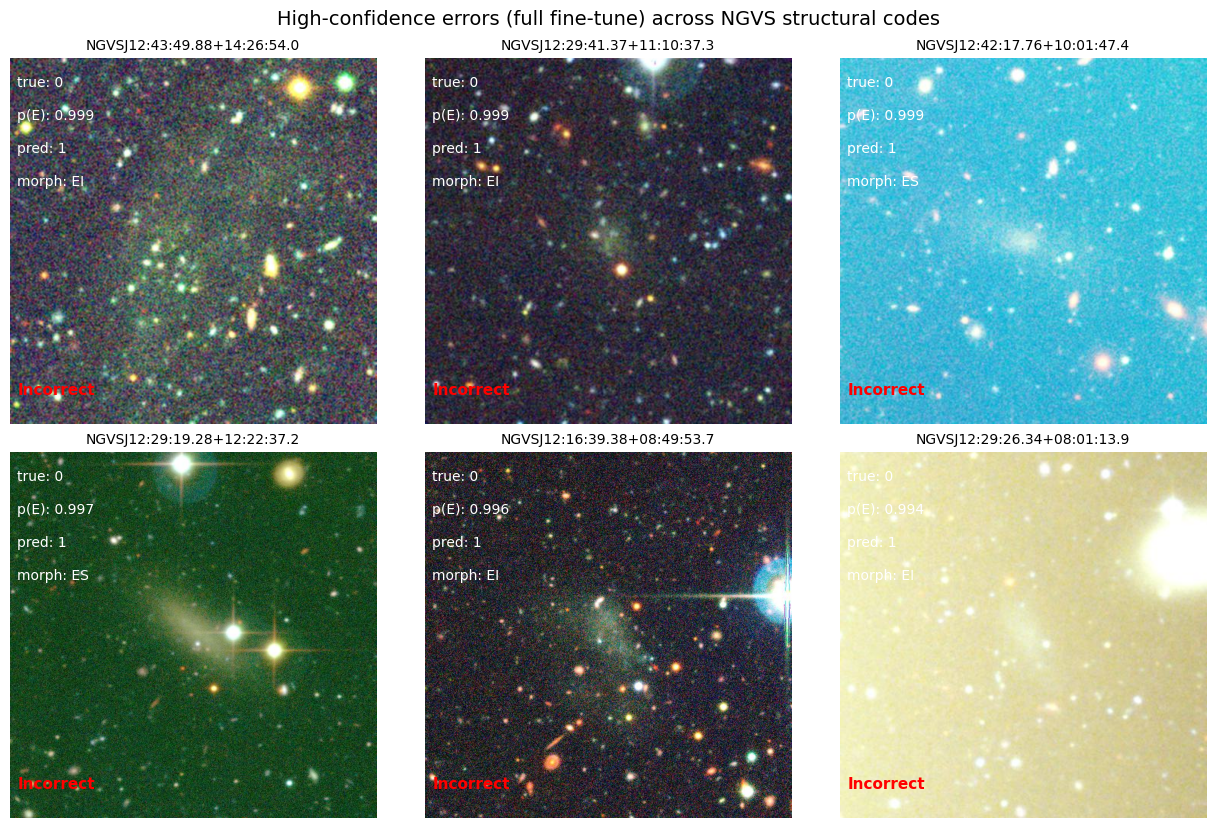

In [54]:
# High-confidence errors: confident in the chosen class but wrong
df["conf_chosen"] = np.where(df["yhat"] == 1, df["p"], 1.0 - df["p"])
worst = (
    df[df["yhat"] != df["y"]]
      .sort_values("conf_chosen", ascending=False)
      .head(6)
)

os.makedirs("outputs/figures", exist_ok=True)
plot_grid(
    worst,
    title="High-confidence errors (full fine-tune) across NGVS morphological subclasses",
    out_png="outputs/figures/high_confidence_errors_full.png"
)


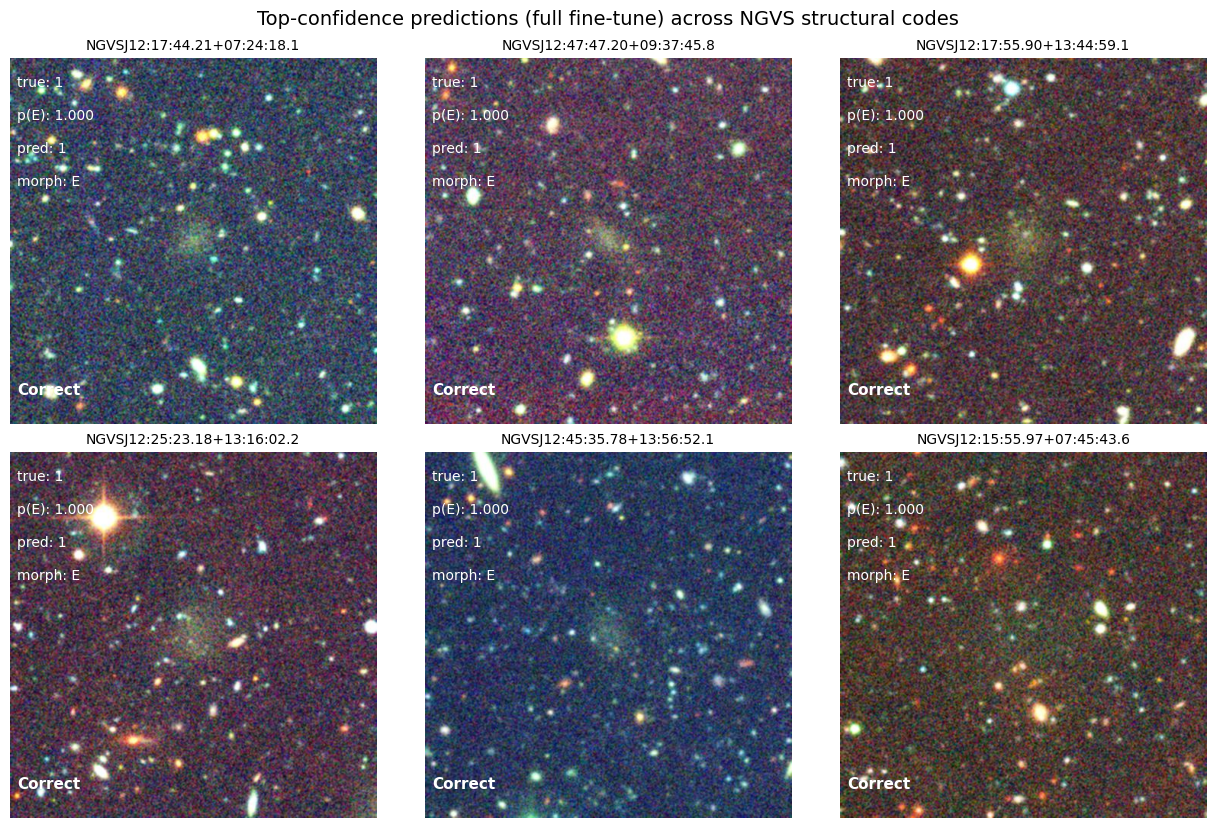

In [55]:
# Top-confidence predictions (sanity check)
top = df.sort_values("p", ascending=False).head(6)

plot_grid(
    top,
    title="Top-confidence predictions (full fine-tune) across NGVS morphological subclasses",
    out_png="outputs/figures/top_confidence_full.png"
)



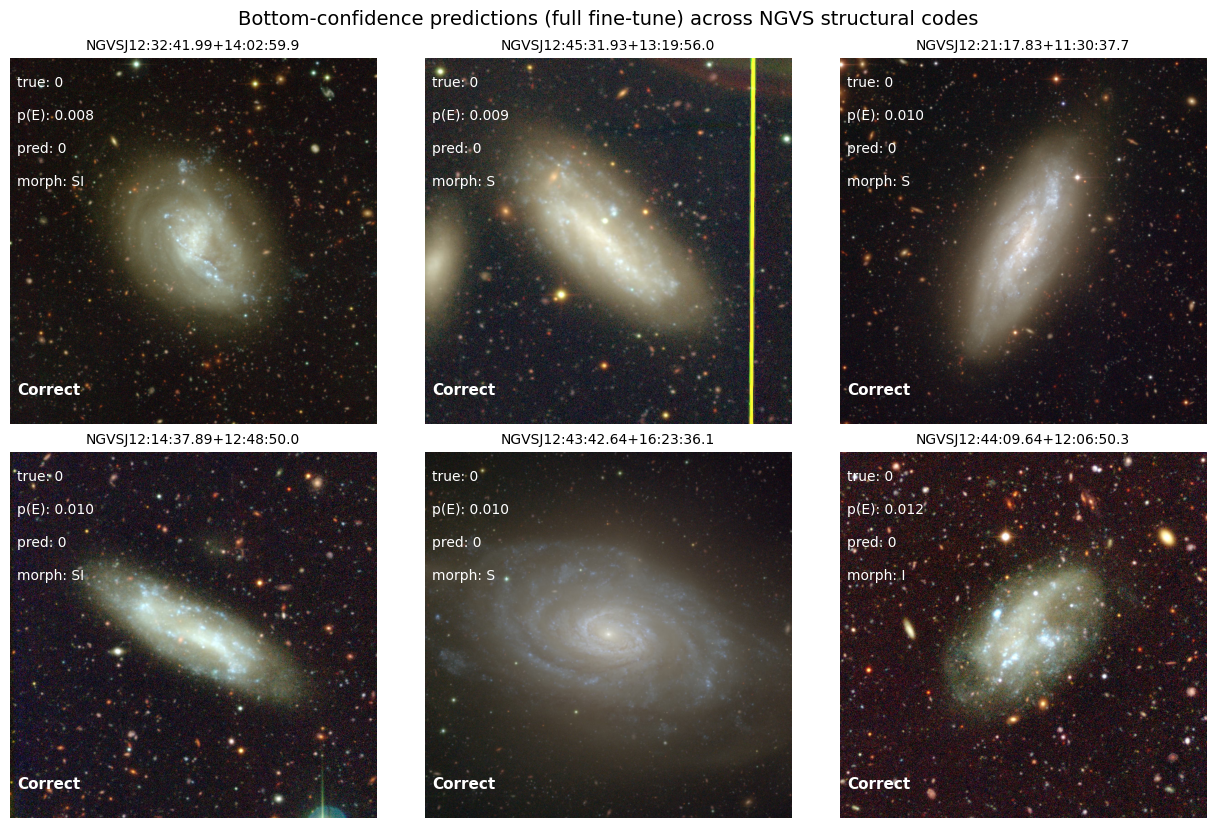

In [56]:
# Lowest p(E) predictions (confident not-E sanity check)
bottom = df.sort_values("p", ascending=True).head(6)

plot_grid(
    bottom,
    title="Lowest p(E) predictions (confident not-E) across NGVS morphological subclasses",
    out_png="outputs/figures/bottom_confidence_full.png"
)



In [65]:
# Decision-boundary examples (p≈0.5): ambiguous / near-transition cases across NGVS morphological subclasses

# Predictions closest to the decision threshold (most ambiguous)
pred_boundary = (
    df.assign(dist_to_thresh=(df["p"] - THRESH).abs())
      .sort_values("dist_to_thresh", ascending=True)
      .head(6)
)

plot_grid(
    pred_boundary,
    title=f"Predictions near the decision boundary (|p(E) - {THRESH:.1f}| small)",
    out_png="outputs/figures/pred_boundary.png",
    n_show=6,
    n_cols=3
)



## How to interpret these results

Errors concentrate near morphological boundaries (e.g., ES/EI), where visual distinctions are subtle and labels are inherently uncertain.
In these regions, the model often assigns high confidence to predictions that are visually plausible but scientifically incorrect, highlighting that confidence alone does not imply reliability when classes are transitional or poorly separated.

Aggregate performance masks structured failure modes that only appear under subgroup or confidence-stratified inspection.
Metrics such as overall accuracy and ROC–AUC remain high even when the model exhibits systematic errors in specific structural subclasses, demonstrating why global metrics are insufficient for assessing reliability under domain shift.

Some misclassifications reflect genuine ambiguity, while others likely reflect label noise or dataset mismatch.
Under limited supervision and heterogeneous data quality, these two sources of error are difficult to disentangle using scalar metrics alone, but become visible through qualitative inspection of edge cases.

Despite these limitations, the model captures broad morphological trends and generalizes reasonably across subclasses.
This supports the use of pretrained vision backbones like ZooBot for scientific applications, while also underscoring the need for targeted evaluation when predictions are used in downstream analyses rather than as exploratory tools.

## Relevance to applied AI safety

This analysis mirrors several challenges that arise in safety-critical ML systems more broadly, particularly when models are deployed under distribution shift and with imperfect supervision.

First, confidently incorrect predictions represent a reliability risk even when aggregate performance is strong. In many real-world settings, systems are trusted most when they appear certain, which makes high-confidence errors especially dangerous. The diagnostics above demonstrate how such failures can remain invisible to standard metrics, motivating evaluation strategies that explicitly target worst-case and confidence-stratified behavior rather than average-case performance.

Second, subgroup-specific failures highlight the importance of slice-based evaluation under heterogeneous data conditions. Here, morphological subclasses act as natural subpopulations with different visual statistics and label ambiguity. Similar dynamics arise in deployed systems where performance varies across user groups, contexts, or rare but critical scenarios. Without targeted slicing, these vulnerabilities can persist unnoticed despite strong overall benchmarks.

Third, label noise and task ambiguity interact with model confidence in ways that complicate oversight. Transitional morphologies illustrate how models can become confident in cases where the underlying ground truth is uncertain or inconsistently labeled. This parallels safety concerns around supervising advanced models using noisy or incomplete feedback, motivating approaches such as weak-to-strong supervision, adversarial evaluation, and model-assisted oversight.

Finally, this workflow reflects an evaluation philosophy that treats failure-mode discovery as a first-class objective, rather than optimizing solely for headline metrics. The emphasis on stress-testing, qualitative inspection, and targeted diagnostics aligns with emerging safety practices such as red-teaming, behavioral probing, and interpretability-guided audits, which aim to surface brittle or deceptive behavior before deployment.

In this sense, although the application domain here is astrophysical imaging, the evaluation methods and failure patterns are directly relevant to broader AI safety concerns around reliability, oversight, and robustness in complex, high-stakes ML systems.

## 5) Scope boundaries and extensions

This curated example intentionally focuses on a single representative run to illustrate evaluation methodology rather than exhaustively reproducing thesis-level results.

Extensions explored in the full research work (but omitted here for clarity and brevity) include:
- Repeating the same evaluation across multiple label-fraction regimes (10%, 25%, 50%) to study label efficiency.
- Detailed calibration analysis using reliability diagrams and multiple operating points.
- Error stratification by physical and contextual variables (e.g., stellar mass, cluster environment).

These extensions follow the same workflow documented here and are described in more detail in the my associated PhD thesis chapter and in the upcoming publication presenting these results.


## Appendix: How the predictions were produced (minimal, reproducible sketch)

. This appendix provides a *transparent sketch* of how the model was fine-tuned and how the predictions in:

- `outputs/tables/multi1090_structural_predictions_agg_v2.csv`

were generated.

### High-level pipeline
1. Build a ZooBot-compatible catalog (`id_str`, `file_loc`, and label columns like `is_E`).
2. Fine-tune a pretrained ZooBot checkpoint under limited supervision (head-only and full fine-tune variants).
3. Run inference over the evaluation catalog and save per-image predicted probabilities.
4. Aggregate predictions into a single analysis table (the `*_agg_v2.csv` files) and generate curated figures.

### Representative training + inference code (excerpt)
The code below is representative of the workflow used in the original experiments. Paths, checkpoint locations, and hyperparameters are simplified for readability.

#### Note 
The following code reflects the actual training and inference workflow used to produce the committed prediction artifacts, with paths and environment details omitted for clarity.

In [ ]:
# --- Representative ZooBot fine-tuning + inference sketch (simplified) ---
import torch
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
from zoobot.pytorch.training import finetune
from zoobot.pytorch.predictions import predict_on_catalog

# 1) Build catalog (must include: id_str, file_loc, and label columns)
catalog = pd.read_csv(CATALOG_CSV)
catalog["id_str"] = catalog["NGVS_name"]
catalog["file_loc"] = catalog["NGVS_name"].apply(lambda s: os.path.join(DATA_DIR, f"{s}.jpeg"))
catalog["is_E"] = (catalog["NGVS_morph_code"] == "E").astype(int)

label_cols = ["is_E"]

datamodule = GalaxyDataModule(
    label_cols=label_cols,
    catalog=catalog,
    batch_size=32,
    resize_after_crop=224,
    num_workers=2,
)

# 2) Fine-tune pretrained ZooBot checkpoint
# - n_layers=0  -> head-only (linear probe)
# - n_layers>0  -> deeper fine-tuning (e.g., full fine-tune)
model = finetune.FinetuneableZoobotClassifier(
    checkpoint_loc=CHECKPOINT_LOC,
    num_classes=2,
    n_layers=2,
)

trainer = finetune.get_trainer(
    save_dir=RUN_DIR,
    accelerator="auto",
    devices="auto",
    max_epochs=EPOCHS,
)
trainer.fit(model, datamodule)

# 3) Load best checkpoint + run predictions to CSV
best_ckpt = trainer.checkpoint_callback.best_model_path
finetuned_model = finetune.FinetuneableZoobotClassifier.load_from_checkpoint(best_ckpt)

predict_on_catalog.predict(
    catalog=catalog,
    model=finetuned_model,
    n_samples=1,
    label_cols=label_cols,
    save_loc=os.path.join(RUN_DIR, "predictions_raw.csv"),
)

# 4) Aggregate into the analysis table used in this repo
#    (e.g., merge with metadata; compare baseline/head/full; compute derived columns)
#    -> outputs/tables/multi1090_structural_predictions_agg_v2.csv
